In [1]:

!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.8.* dask-cudf-cu12==24.8.* cuml-cu12==24.8.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.7/516.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 645.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.6/129.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.8/783.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 93.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.0/916.0 kB 

In [2]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [1]:
NGRAM_RANGE = (1, 2)
NORM = "l2"
SUBLINER_TF = True
test_size= 0.25
random_state = 42
n_estimators = 1000
max_depth = 12
C =2
max_iter = 1000
n_jobs =-1
voting = 'soft'
weights = [1,2,3,4]
probability= True

In [2]:
# %load_ext cudf.pandas
import pandas as pd

In [2]:
import os
os.makedirs("/content/drive/MyDrive/SubjectClassifier_10k",exist_ok=True)
os.chdir('/content/drive/MyDrive/SubjectClassifier_10k')

In [3]:
# Check GPU availability
!nvidia-smi


Mon Sep  9 12:15:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os
os.makedirs("/content/drive/MyDrive/SubjectClassifier_10k/model",exist_ok=True)
os.makedirs("/content/drive/MyDrive/SubjectClassifier_10k/train_data",exist_ok=True)
os.makedirs("/content/drive/MyDrive/SubjectClassifier_10k/eval_data",exist_ok=True)

In [6]:
from pathlib import Path
import joblib
import os
# import cudf
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
import sys

In [27]:
import os
import cudf
import cuml
import cupy as cp
import joblib
import pandas as pd
from pathlib import Path
from cuml.feature_extraction.text import TfidfVectorizer,CountVectorizer
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
# from xgboost import
from sklearn.model_selection import GridSearchCV,StratifiedKFold

class Training:
    def __init__(self):
        self.train_data_path = "/content/17k_synthetic_data (1).csv"
        self.output_path = "/content/drive/MyDrive/subjectclassifier"

    def prepare_data(self):
        # Load data
        train_data_path="/content/17k_synthetic_data (1).csv"
        data=cudf.read_csv(train_data_path).sample(10000)

        #preprocessing
        # data['sentence']=data['sentence'].fillna("")

        # #train test split
        # x_train, x_test, y_train, y_test = train_test_split(data["sentence"],data["subject"], test_size = test_size, random_state =random_state)

        # # Convert to cudf Series if they're not already
        # if isinstance(x_train, pd.Series):
        #     x_train = cudf.Series(x_train)
        # elif isinstance(x_train, np.ndarray):
        #     x_train = cudf.Series(x_train.flatten())

        # if isinstance(x_test, pd.Series):
        #     x_test = cudf.Series(x_test)
        # elif isinstance(x_test, np.ndarray):
        #     x_test = cudf.Series(x_test.flatten())

        # # Create the TF-IDF pipeline
        # tfidf_pipeline = Pipeline([
        #     ('tfidf', TfidfVectorizer())
        # ])

        # # Fit and transform the training data
        # x_train_tfidf = tfidf_pipeline.fit_transform(x_train)

        # # Transform the test data
        # x_test_tfidf = tfidf_pipeline.transform(x_test)
        # # Save eval data
        # pd.DataFrame(x_test_tfidf.toarray()).to_csv("/content/drive/MyDrive/subjectclssifier/eval_data/X_testtfidf_data.csv")
        # pd.DataFrame(y_test).to_csv("/content/drive/MyDrive/subjectclssifier/eval_data/y_test_data.csv")

        # # Save train data
        # pd.DataFrame(x_train_tfidf.toarray()).to_csv("/content/drive/MyDrive/subjectclssifier/train_data/X_traintfidf_data.csv")
        # pd.DataFrame(y_train).to_csv("/content/drive/MyDrive/subjectclssifier/train_data/y_train_data.csv")

        # # Save pipeline
        # path = "/content/drive/MyDrive/subjectclssifier/model/n_gram_tfidf_model"
        # joblib.dump(tfidf_pipeline, path)

    def train_ensemble_model(self):
        # Load data
        x_train_tfidf = cudf.read_csv(f"{self.output_path}/train_data/X_traintfidf_data.csv", index_col=0)
        y_train = cudf.read_csv(f"{self.output_path}/train_data/y_train_data.csv", index_col=0)

        # Convert y_train to 1D array
        y_train = y_train.values.ravel()

        # Model creation
        mnb = MultinomialNB()
        rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        lr = LogisticRegression(C=1.0, max_iter=1000)
        svc = SVC(probability=True)

        ec = VotingClassifier(estimators=[
            ('Multinominal NB', mnb),
            ('Random Forest', rfc),
            ('Logistic Regression', lr),
            ('Support Vector Machine', svc)
        ], voting='soft')

        # Train
        ec.fit(x_train_tfidf, y_train)

        # Save the ensemble model
        path = f"{self.output_path}/model/ensemble_model.pkl"
        cuml.save(ec, path)
        print(f"Ensemble model saved at {path}")

    def load_ensemble_model(self):
        path = f"{self.output_path}/model/ensemble_model.pkl"
        return cuml.load(path)

In [ ]:
NGRAM_RANGE = (1, 2)
NORM = 'l2'
SUBLINER_TF = True
test_size = 0.2
random_state = 42
import numpy as np
train_data_path = "/content/17k_synthetic_data (1).csv"
data = pd.read_csv(train_data_path)
data=pd.read_csv(train_data_path).sample(10000)

# Preprocessing
data['sentence'] = data['sentence'].fillna("")

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(data["sentence"], data["subject"], test_size=test_size, random_state=random_state)

# Pipeline creation
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=NGRAM_RANGE)),
    ('tfidf', TfidfVectorizer(norm=NORM, sublinear_tf=SUBLINER_TF))
])


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cudf
# Convert to cudf Series if they're not already
if isinstance(x_train, pd.Series):
    x_train = cudf.Series(x_train)
elif isinstance(x_train, np.ndarray):
    x_train = cudf.Series(x_train.flatten())

if isinstance(x_test, pd.Series):
    x_test = cudf.Series(x_test)
elif isinstance(x_test, np.ndarray):
    x_test = cudf.Series(x_test.flatten())

# Create the TF-IDF pipeline
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer())
])

# Fit and transform the training data
x_train_tfidf = tfidf_pipeline.fit_transform(x_train)

# Transform the test data
x_test_tfidf = tfidf_pipeline.transform(x_test)
# # Save pipeline
path = "/content/drive/MyDrive/SubjectClassifier_10k/model/n_gram_tfidf_model.pkl"
joblib.dump(tfidf_pipeline, path)

['/content/drive/MyDrive/SubjectClassifier_10k/model/n_gram_tfidf_model.pkl']

In [ ]:
# Save eval data
pd.DataFrame(x_test_tfidf.toarray()).to_csv("/content/drive/MyDrive/SubjectClassifier_10k/eval_data/X_testtfidf_data.csv")
pd.DataFrame(y_test).to_csv("/content/drive/MyDrive/SubjectClassifier_10k/eval_data/y_test_data.csv")

# Save train data
pd.DataFrame(x_train_tfidf.toarray()).to_csv("/content/drive/MyDrive/SubjectClassifier_10k/train_data/X_traintfidf_data.csv")
pd.DataFrame(y_train).to_csv("/content/drive/MyDrive/SubjectClassifier_10k/train_data/y_train_data.csv")


In [ ]:
# # Save pipeline
# path = "/content/drive/MyDrive/subjectclassifier/model/n_gram_tfidf_model.pkl"
# joblib.dump(tfidf_pipeline, path)


# /content/drive/MyDrive/subjectclassifier/model/n_gram_tfidf_model.pkl


In [28]:
# Load data
output_path="/content/drive/MyDrive/SubjectClassifier_10k"
# x_train_tfidf = cudf.read_csv(f"{output_path}/train_data/X_traintfidf_data.csv", index_col=0)
# y_train = cudf.read_csv(f"{output_path}/train_data/y_train_data.csv", index_col=0)
x_train_tfidf = pd.read_csv(f"{output_path}/train_data/X_traintfidf_data.csv", index_col=0)
y_train = pd.read_csv(f"{output_path}/train_data/y_train_data.csv", index_col=0)
# Convert y_train to 1D array
# y_train = y_train.values.ravel()/

# Model creation|
mnb = MultinomialNB()
rfc = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
lr = LogisticRegression(C=1.0, max_iter=1000)
svc = SVC(probability=True,kernel='rbf',C=1)

#

ec = VotingClassifier(estimators=[
    ('Multinominal NB', mnb),
    ('Random Forest', rfc),
    ('Logistic Regression', lr),
    ('Support Vector Machine', svc)
], voting='soft',weights=(1,2,1,1))





**CUML VOTING MODEL**

In [29]:
# Train
%%time
ec.fit(x_train_tfidf, y_train.to_numpy().ravel())

CPU times: user 59min 10s, sys: 17.6 s, total: 59min 28s
Wall time: 1h 48s


VotingClassifier(estimators=[('Multinominal NB', MultinomialNB()),
                             ('Random Forest', RandomForestClassifier()),
                             ('Logistic Regression', LogisticRegression()),
                             ('Support Vector Machine',
                              SVC(C=1, probability=True))],
                 voting='soft', weights=(1, 2, 1, 1))

**SK Learn voting model**

In [13]:
# Train
%%time
ec.fit(x_train_tfidf, y_train)

CPU times: user 1h 25min 5s, sys: 22.2 s, total: 1h 25min 27s
Wall time: 1h 25min 24s


VotingClassifier(estimators=[('Multinominal NB', MultinomialNB()),
                             ('Random Forest',
                              RandomForestClassifier(max_depth=10,
                                                     random_state=42)),
                             ('Logistic Regression',
                              LogisticRegression(max_iter=1000)),
                             ('Support Vector Machine', SVC(probability=True))],
                 voting='soft')

In [30]:
# Save the ensemble model
path = f"{output_path}/model/cuml_voting_ensemble_model.pkl"
joblib.dump(ec, path)
print(f"Ensemble model saved at {path}")

Ensemble model saved at /content/drive/MyDrive/SubjectClassifier_10k/model/cuml_voting_ensemble_model.pkl


In [4]:
import os
import time
import logging
import json
from pathlib import Path

import cudf
import cuml
import cupy as cp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import os
# import cudf
# import cuml
# import cupy as cp
import joblib
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
# from xgboost import
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [ ]:
%%time
output_path="/content/drive/MyDrive/SubjectClassifier_10k"
trained_model_path = f"{output_path}/model/sklearn_voting_ensemble_model.pkl"
ec = joblib.load(trained_model_path)
x_test_tfidf = pd.read_csv(f"{output_path}/eval_data/X_testtfidf_data.csv", index_col=0)
y_test = pd.read_csv(f"{output_path}/eval_data/y_test_data.csv", index_col=0)
print("Loaded all the train and test files successfully")
x = time.time()

# Make predictions
y_pred = ec.predict(x_test_tfidf)
y = time.time()
print(f"Time taken for prediction: {y-x}")
# y_test=y_test.values.ravel()
# Calculate scores
print("Calculating metrics")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1_score = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Cross-validation (Note: cuML doesn't have cross_val_score, so we'll skip this for now)
z = time.time()
print(f"Time taken for evaluation: {z-y}")

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")
print(f"Recall: {recall}")

Loaded all the train and test files successfully


**using sklearn**

In [5]:
%%time
output_path="/content/drive/MyDrive/SubjectClassifier_10k"
trained_model_path = f"{output_path}/model/sklearn_voting_ensemble_model.pkl"
ec = joblib.load(trained_model_path)
x_test_tfidf = pd.read_csv(f"{output_path}/eval_data/X_testtfidf_data.csv", index_col=0)
y_test = pd.read_csv(f"{output_path}/eval_data/y_test_data.csv", index_col=0)
print("Loaded all the train and test files successfully")
x = time.time()

# Make predictions
y_pred = ec.predict(x_test_tfidf)
y = time.time()
print(f"Time taken for prediction: {y-x}")
y_test=y_test.values.ravel()
# Calculate scores
print("Calculating metrics")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1_score = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Cross-validation (Note: cuML doesn't have cross_val_score, so we'll skip this for now)
z = time.time()
print(f"Time taken for evaluation: {z-y}")

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")
print(f"Recall: {recall}")

Loaded all the train and test files successfully
Time taken for prediction: 162.94085049629211
Calculating metrics
Time taken for evaluation: 0.04651045799255371
Accuracy: 0.8115
Precision: 0.8173293961566176
F1 Score: 0.8105002220618465
Recall: 0.8115
CPU times: user 2min 39s, sys: 1.53 s, total: 2min 41s
Wall time: 2min 58s


In [32]:
scores = {
    "accuracy": accuracy,
    "precision": precision,
    "f1_score": f1_score,
    "recall": recall
}
# if grid_search:
#     scores["best_params"] = grid_search.best_params_
#     scores["best_score"] = grid_search.best_score_

path = Path("/content/drive/MyDrive/SubjectClassifier_10k/cuml_scores_10k_data.json")
with open(path, 'w') as f:
    json.dump(scores, f)

In [ ]:
# %%time
# # Define parameter grid
# param_grid = {
#     'voting': ['hard', 'soft'],
#     'weights': [(1, 1, 1, 1), (1, 2, 1, 1), (1, 1, 2, 1)],
#     'Random Forest__n_estimators': [50, 100, 200],
#     'Random Forest__max_depth': [10, 20, 30, None],
#     'Logistic Regression__C': [0.1, 1, 10],
#     'Support Vector Machine__C': [0.1, 1, 10],
#     'Support Vector Machine__kernel': ['linear', 'rbf'],
# }

# # Define models
# mnb = MultinomialNB()
# rfc = RandomForestClassifier(random_state=42)
# lr = LogisticRegression(max_iter=1000)
# svc = SVC(probability=True)

# # Create a VotingClassifier
# ec = VotingClassifier(estimators=[
#     ('Multinominal NB', mnb),
#     ('Random Forest', rfc),
#     ('Logistic Regression', lr),
#     ('Support Vector Machine', svc)]
# )

# # Initialize GridSearchCV
# grid_search_= GridSearchCV(estimator=ec, param_grid=param_grid, cv=10, verbose=1)

# # Fit the grid search to the data
# grid_search_.fit(x_train_tfidf, y_train)

# # Get the best model
# best_model_ = grid_search_.best_estimator_

# # Print the best parameters and score
# print(f"Best Parameters: {grid_search_.best_params_}")
# print(f"Best Cross-validation Score: {grid_search_.best_score_}")


In [33]:
%%time
y_pred_proba=ec.predict_proba(x_test_tfidf)
y_pred_proba

CPU times: user 3min 16s, sys: 1.17 s, total: 3min 17s
Wall time: 3min 20s


array([[0.03285886, 0.01732828, 0.0187416 , ..., 0.01990489, 0.01972046,
        0.03055707],
       [0.19441471, 0.03354362, 0.00902257, ..., 0.01267809, 0.01136331,
        0.01021875],
       [0.02864398, 0.01376557, 0.01586604, ..., 0.01988641, 0.01493627,
        0.01775574],
       ...,
       [0.02504717, 0.01981569, 0.02116557, ..., 0.0240842 , 0.01585412,
        0.02847152],
       [0.02382888, 0.01408848, 0.0133407 , ..., 0.02384704, 0.01356649,
        0.01682739],
       [0.04439021, 0.01578611, 0.01679097, ..., 0.03523372, 0.02588179,
        0.03771018]])

sk

In [7]:
%%time
y_pred_proba=ec.predict_proba(x_test_tfidf)
y_pred_proba

CPU times: user 2min 34s, sys: 435 ms, total: 2min 34s
Wall time: 2min 36s


array([[0.03285886, 0.01732828, 0.0187416 , ..., 0.01990489, 0.01972046,
        0.03055707],
       [0.19441471, 0.03354362, 0.00902257, ..., 0.01267809, 0.01136331,
        0.01021875],
       [0.02864398, 0.01376557, 0.01586604, ..., 0.01988641, 0.01493627,
        0.01775574],
       ...,
       [0.02504717, 0.01981569, 0.02116557, ..., 0.0240842 , 0.01585412,
        0.02847152],
       [0.02382888, 0.01408848, 0.0133407 , ..., 0.02384704, 0.01356649,
        0.01682739],
       [0.04439021, 0.01578611, 0.01679097, ..., 0.03523372, 0.02588179,
        0.03771018]])

In [8]:
path = "/content/drive/MyDrive/SubjectClassifier_10k/model/n_gram_tfidf_model.pkl"
tfidf=joblib.load(path)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

class ClassificationEvaluator:
    def __init__(self, model, X_test, y_test, y_pred,y_pred_proba,class_names):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.y_pred = y_pred
        self.y_pred_proba = y_pred_proba

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def print_classification_report(self):
        report = classification_report(self.y_test, self.y_pred, target_names=self.class_names)
        print("Classification Report:")
        print(report)

    def plot_roc_curve(self):
        n_classes = len(self.class_names)
        y_test_bin = label_binarize(self.y_test, classes=range(n_classes))

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], self.y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 8))
        colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of class {self.class_names[i]} (area = {roc_auc[i]:0.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    def plot_prediction_distribution(self):
        plt.figure(figsize=(10, 6))
        for i, class_name in enumerate(self.class_names):
            sns.kdeplot(self.y_pred_proba[:, i], shade=True, label=class_name)
        plt.title('Prediction Probability Distribution')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.legend()
        plt.show()


cuml

Evaluating the best model from grid search...


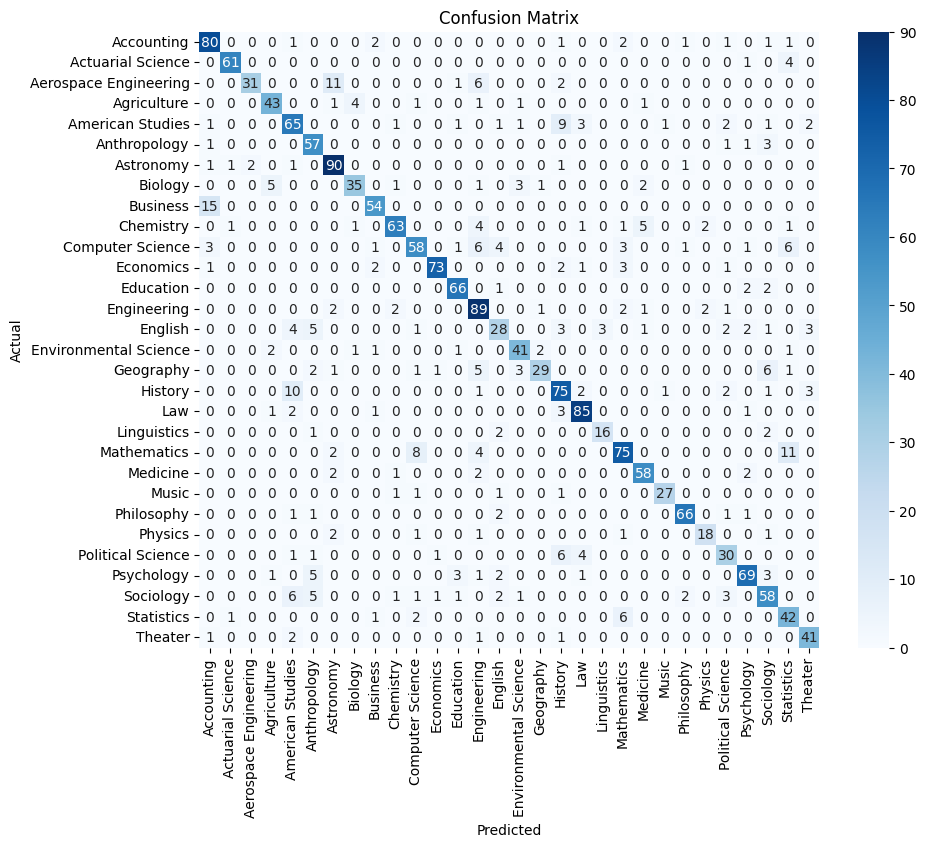

In [34]:
import warnings
warnings.filterwarnings("ignore")
# Assuming the grid search code has been run and best_model_ is available

# Get unique classes from y_train or y_test
class_names = np.unique(y_test)

# Create an instance of ClassificationEvaluator
evaluator = ClassificationEvaluator(ec, x_test_tfidf, y_test, y_pred,y_pred_proba, class_names)

# Perform evaluations
print("Evaluating the best model from grid search...")
evaluator.plot_confusion_matrix()

In [35]:
print("\n classification Report \n")
evaluator.print_classification_report()



 classification Report 

Classification Report:
                       precision    recall  f1-score   support

           Accounting       0.78      0.89      0.83        90
    Actuarial Science       0.95      0.92      0.94        66
Aerospace Engineering       0.94      0.61      0.74        51
          Agriculture       0.83      0.83      0.83        52
     American Studies       0.70      0.74      0.72        88
         Anthropology       0.74      0.90      0.81        63
            Astronomy       0.81      0.93      0.87        97
              Biology       0.85      0.73      0.79        48
             Business       0.87      0.78      0.82        69
            Chemistry       0.90      0.80      0.85        79
     Computer Science       0.78      0.69      0.73        84
            Economics       0.96      0.88      0.92        83
            Education       0.89      0.93      0.91        71
          Engineering       0.73      0.89      0.80       100
     


 ROC Curve 



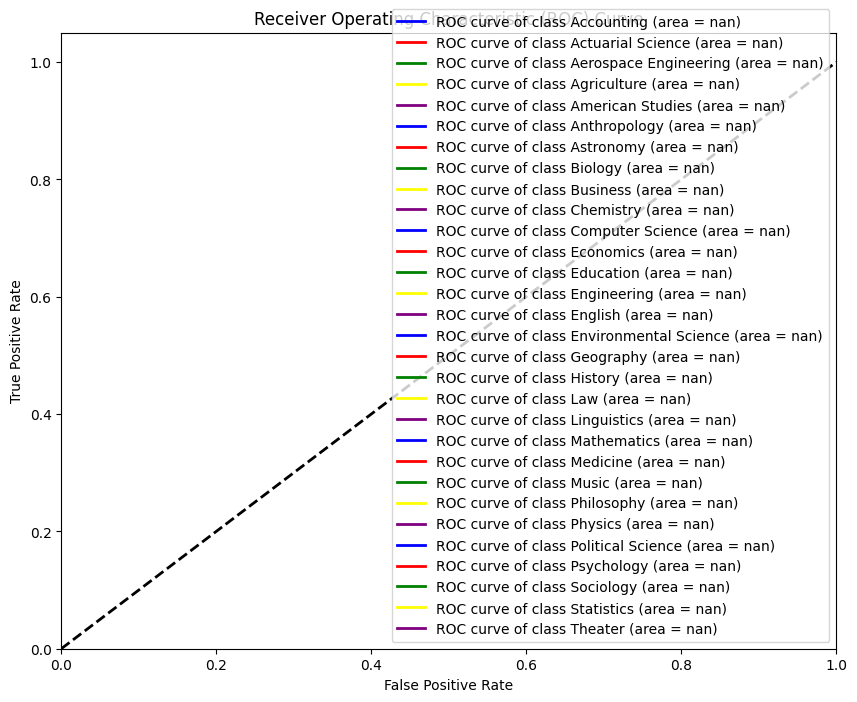

In [36]:
print("\n ROC Curve \n")
evaluator.plot_roc_curve()



 plot_prediction_distribution 



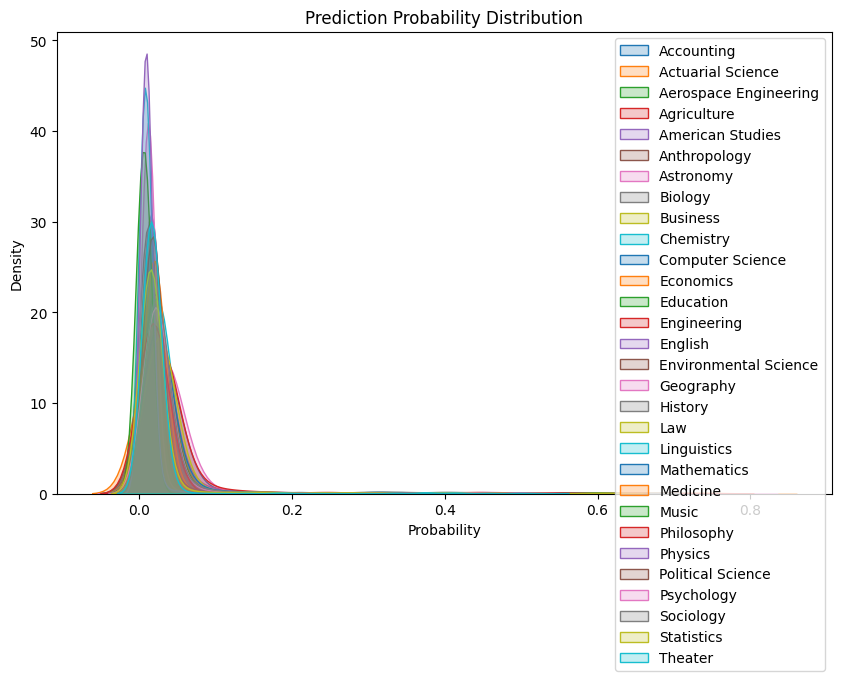

In [37]:
print("\n plot_prediction_distribution \n")
evaluator.plot_prediction_distribution()

sk

Evaluating the best model from grid search...


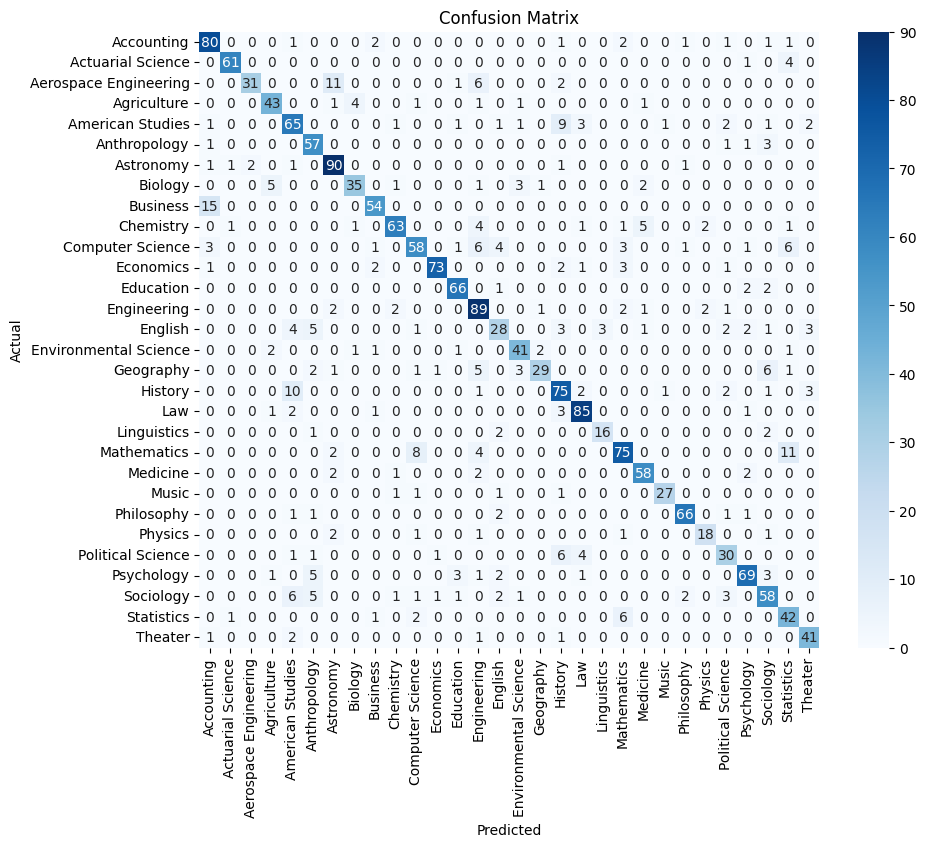

In [13]:
import warnings
warnings.filterwarnings("ignore")
# Assuming the grid search code has been run and best_model_ is available

# Get unique classes from y_train or y_test
class_names = np.unique(y_test)

# Create an instance of ClassificationEvaluator
evaluator = ClassificationEvaluator(ec, x_test_tfidf, y_test, y_pred,y_pred_proba, class_names)

# Perform evaluations
print("Evaluating the best model from grid search...")
evaluator.plot_confusion_matrix()




In [14]:
print("\n classification Report \n")
evaluator.print_classification_report()



 classification Report 

Classification Report:
                       precision    recall  f1-score   support

           Accounting       0.78      0.89      0.83        90
    Actuarial Science       0.95      0.92      0.94        66
Aerospace Engineering       0.94      0.61      0.74        51
          Agriculture       0.83      0.83      0.83        52
     American Studies       0.70      0.74      0.72        88
         Anthropology       0.74      0.90      0.81        63
            Astronomy       0.81      0.93      0.87        97
              Biology       0.85      0.73      0.79        48
             Business       0.87      0.78      0.82        69
            Chemistry       0.90      0.80      0.85        79
     Computer Science       0.78      0.69      0.73        84
            Economics       0.96      0.88      0.92        83
            Education       0.89      0.93      0.91        71
          Engineering       0.73      0.89      0.80       100
     


 ROC Curve 



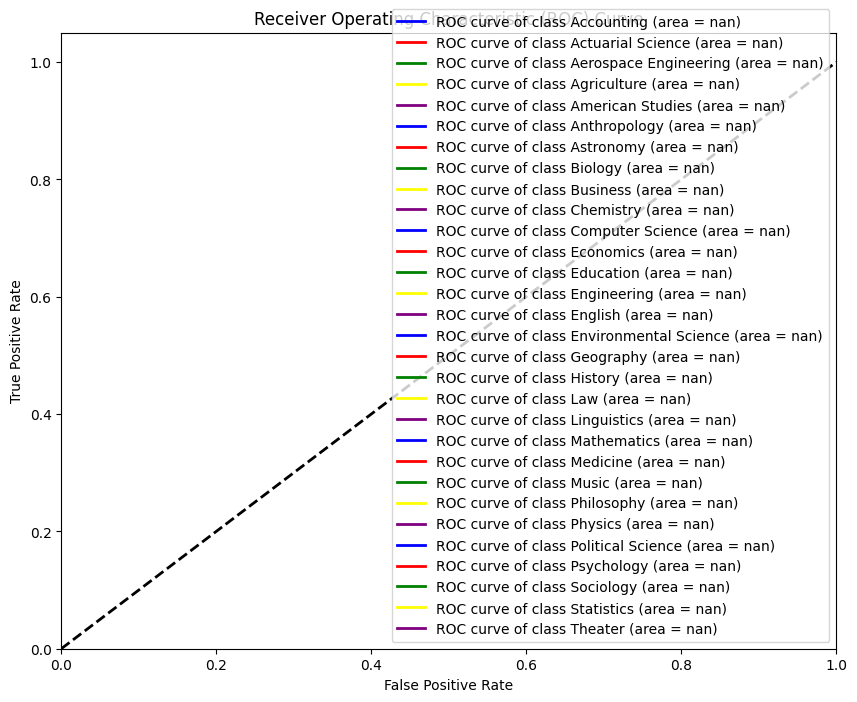

In [15]:
print("\n ROC Curve \n")
evaluator.plot_roc_curve()



 plot_prediction_distribution 



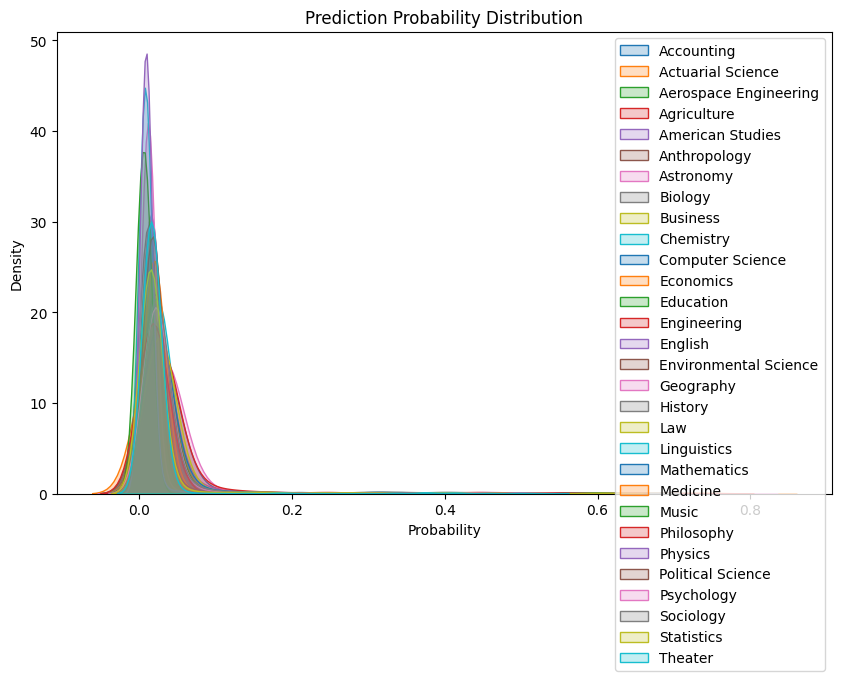

In [16]:
print("\n plot_prediction_distribution \n")
evaluator.plot_prediction_distribution()

In [ ]:
# # Additional analysis
# print("\nBest Model Details:")
# for name, model in best_model_.named_estimators_.items():
#     print(f"\n{name}:")
#     if hasattr(model, 'feature_importances_'):
#         importances = model.feature_importances_
#         indices = np.argsort(importances)[::-1]
#         top_features = 10
#         print(f"Top {top_features} important features:")
#         feature_names = tfidf.get_feature_names()  # Assuming tfidf is your TfidfVectorizer
#         for f in range(top_features):
#             print("%d. feature '%s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))
#     elif hasattr(model, 'coef_'):
#         coef = model.coef_[0]
#         indices = np.argsort(np.abs(coef))[::-1]
#         top_features = 10
#         print(f"Top {top_features} important features:")
#         feature_names = tfidf.get_feature_names()  # Assuming tfidf is your TfidfVectorizer
#         for f in range(top_features):
#             print("%d. feature '%s' (%f)" % (f + 1, feature_names[indices[f]], coef[indices[f]]))
#     else:
#         print("No feature importance information available.")

# # Save the best model
# import joblib
# joblib.dump(best_model_, 'best_ensemble_model.joblib')
# print("\nBest model saved as 'best_ensemble_model.joblib'")

In [ ]:
# import os
# import cudf

# import cuml
# import numpy as np
# import pandas as pd
# from pathlib import Path
# from cuml.feature_extraction.text import TfidfVectorizer
# from cuml.ensemble import RandomForestClassifier
# from cuml.linear_model import LogisticRegression
# from cuml.svm import SVC
# from cuml.naive_bayes import MultinomialNB
# from sklearn.ensemble import VotingClassifier
# from cuml.model_selection import train_test_split

# class Training:
#     def __init__(self):
#         self.train_data_path = "/content/17k_synthetic_data (1).csv"
#         self.output_path = "/content/drive/MyDrive/subjectclassifier"

#     def prepare_data(self):
#         # Load data
#         data = pd.read_csv(self.train_data_path)  # Use pandas to read CSV

#         # Preprocessing
#         data['sentence'] = data['sentence'].fillna("").astype('str')
#         data['subject'] = data['subject'].astype('category')

#         # Train test split
#         x_train, x_test, y_train, y_test = train_test_split(data["sentence"], data["subject"], test_size=0.2, random_state=42)

#         # Convert to cuDF Series
#         x_train = cudf.Series(x_train)
#         x_test = cudf.Series(x_test)
#         y_train = cudf.Series(y_train)
#         y_test = cudf.Series(y_test)

#         # Create and apply TF-IDF vectorizer
#         tfidf = TfidfVectorizer()
#         x_train_tfidf = tfidf.fit_transform(x_train)
#         x_test_tfidf = tfidf.transform(x_test)

#         # Save eval data
#         cudf.DataFrame(x_test_tfidf).to_csv(f"{self.output_path}/eval_data/X_testtfidf_data.csv")
#         y_test.to_frame().to_csv(f"{self.output_path}/eval_data/y_test_data.csv")

#         # Save train data
#         cudf.DataFrame(x_train_tfidf).to_csv(f"{self.output_path}/train_data/X_traintfidf_data.csv")
#         y_train.to_frame().to_csv(f"{self.output_path}/train_data/y_train_data.csv")

#         # Save TF-IDF vectorizer
#         cuml.save(tfidf, f"{self.output_path}/model/tfidf_vectorizer")

#     def train_ensemble_model(self):
#         # Load data
#         x_train_tfidf = cudf.read_csv(f"{self.output_path}/train_data/X_traintfidf_data.csv", index_col=0)
#         y_train = cudf.read_csv(f"{self.output_path}/train_data/y_train_data.csv", index_col=0)

#         # Convert y_train to 1D array
#         y_train = y_train.values.ravel()

#         # Model creation
#         mnb = MultinomialNB()
#         rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
#         lr = LogisticRegression(C=1.0, max_iter=1000)
#         svc = SVC(probability=True)

#         ec = VotingClassifier(estimators=[
#             ('Multinominal NB', mnb),
#             ('Random Forest', rfc),
#             ('Logistic Regression', lr),
#             ('Support Vector Machine', svc)
#         ], voting='soft')

#         # Train
#         ec.fit(x_train_tfidf, y_train)

#         # Save the ensemble model
#         path = f"{self.output_path}/model/ensemble_model.pkl"
#         cuml.save(ec, path)
#         print(f"Ensemble model saved at {path}")

#     def load_ensemble_model(self):
#         path = f"{self.output_path}/model/ensemble_model.pkl"
#         return cuml.load(path)

# if __name__ == "__main__":
#     trainer = Training()
#     trainer.prepare_data()
#     trainer.train_ensemble_model()
#     loaded_model = trainer.load_ensemble_model()
#     print("Model loaded successfully!")

RuntimeError: Failed to register the 'cudf' backend for dask-expr. Please make sure you have dask-expr installed.
Error Message: cannot import name 'PANDAS_GE_200' from 'dask.dataframe._compat' (/usr/local/lib/python3.10/dist-packages/dask/dataframe/_compat.py)

In [ ]:
# trainer = Training()

In [ ]:
# trainer.prepare_data()

In [ ]:
import os
import time
import logging
import json
from pathlib import Path

import cudf
import cuml
import cupy as cp
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from cuml.naive_bayes import MultinomialNB
from cuml.ensemble import VotingClassifier
from cuml.model_selection import train_test_split, GridSearchCV
from cuml.metrics import accuracy_score, precision_score, f1_score, recall_score

class Evaluation:
    def __init__(self):
        self.load_data()
        self.best_model = None
        self.grid_search = None
        self.accuracy = None
        self.precision = None
        self.f1_score = None
        self.recall = None
        self.scores = None

    def load_data(self):
        # Load data and convert to cuDF DataFrames
        self.x_train = cudf.read_csv(os.path.join("train_data", "X_train_data.csv"), index_col=0, header=0)
        self.x_test = cudf.read_csv(os.path.join("eval_data", "X_test_data.csv"), index_col=0, header=0)
        self.y_train = cudf.read_csv(os.path.join("train_data", "y_train_data.csv"), index_col=0, header=0)
        self.y_test = cudf.read_csv(os.path.join("eval_data", "y_test_data.csv"), index_col=0, header=0)

        # Reset index and convert to 1D arrays
        self.x_train = self.x_train.reset_index(drop=True)
        self.x_test = self.x_test.reset_index(drop=True)
        self.y_train = self.y_train.reset_index(drop=True).values.ravel()
        self.y_test = self.y_test.reset_index(drop=True).values.ravel()

    def apply_tfidf(self):
        # Create and apply TF-IDF vectorizer
        tfidf = TfidfVectorizer()
        self.x_train_tfidf = tfidf.fit_transform(self.x_train)
        self.x_test_tfidf = tfidf.transform(self.x_test)

    def evaluation(self):
        # Load the trained model
        trained_model_path = os.path.join("model", "Text_Ensemble.pkl")
        ec = cuml.load(trained_model_path)

        logging.info("Loaded all the train and test files successfully")
        x = time.time()

        # Make predictions
        y_pred = ec.predict(self.x_test_tfidf)
        y = time.time()
        logging.info(f"Time taken for prediction: {y-x}")

        # Calculate scores
        logging.info("Calculating metrics")
        self.accuracy = accuracy_score(self.y_test, y_pred)
        self.precision = precision_score(self.y_test, y_pred, average='weighted')
        self.f1_score = f1_score(self.y_test, y_pred, average='weighted')
        self.recall = recall_score(self.y_test, y_pred, average='weighted')

        # Cross-validation (Note: cuML doesn't have cross_val_score, so we'll skip this for now)
        z = time.time()
        logging.info(f"Time taken for evaluation: {z-y}")

        # Print results
        logging.info(f"Accuracy: {self.accuracy}")
        logging.info(f"Precision: {self.precision}")
        logging.info(f"F1 Score: {self.f1_score}")
        logging.info(f"Recall: {self.recall}")

    def save_score(self):
        scores = {
            "accuracy": self.accuracy,
            "precision": self.precision,
            "f1_score": self.f1_score,
            "recall": self.recall
        }
        if self.grid_search:
            scores["best_params"] = self.grid_search.best_params_
            scores["best_score"] = self.grid_search.best_score_

        path = Path("scores.json")
        with open(path, 'w') as f:
            json.dump(scores, f)
        logging.info(f"Saved scores at {path}")
        return scores

    def fine_tune(self):
        # Define parameter grid
        param_grid = {
            'voting': ['hard', 'soft'],
            'weights': [(1, 1, 1, 1), (1, 2, 1, 1), (1, 1, 2, 1)],
            'Random Forest__n_estimators': [50, 100, 200],
            'Random Forest__max_depth': [10, 20, 30, None],
            'Logistic Regression__C': [0.1, 1, 10],
            'Support Vector Machine__C': [0.1, 1, 10],
            'Support Vector Machine__kernel': ['linear', 'rbf'],
        }

        # Define models
        mnb = MultinomialNB()
        rfc = RandomForestClassifier(random_state=42)
        lr = LogisticRegression(max_iter=1000)
        svc = SVC(probability=True)

        # Create a VotingClassifier
        ec = VotingClassifier(estimators=[
            ('Multinominal NB', mnb),
            ('Random Forest', rfc),
            ('Logistic Regression', lr),
            ('Support Vector Machine', svc)]
        )

        # Initialize GridSearchCV
        self.grid_search = GridSearchCV(estimator=ec, param_grid=param_grid, cv=5, verbose=1)

        # Fit the grid search to the data
        self.grid_search.fit(self.x_train_tfidf, self.y_train)

        # Get the best model
        self.best_model = self.grid_search.best_estimator_

        # Print the best parameters and score
        print(f"Best Parameters: {self.grid_search.best_params_}")
        print(f"Best Cross-validation Score: {self.grid_search.best_score_}")

        # Evaluate the best model on the test set
        y_pred = self.best_model.predict(self.x_test_tfidf)
        self.accuracy = accuracy_score(self.y_test, y_pred)

        print(f"Test Accuracy: {self.accuracy}")

        # Save the scores including hyperparameter tuning results
        self.save_score()


In [ ]:

eval = Evaluation()
eval.apply_tfidf()


In [ ]:
eval.evaluation()
eval.fine_tune()